In [3]:
pip install keras_tuner

  Using cached keras_tuner-1.1.0-py3-none-any.whl (98 kB)
  Using cached kt_legacy-1.0.4-py3-none-any.whl (9.6 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import altair as alt
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras_tuner as kt

2.7.0


In [1]:
# import dataset into colab
%store -r IMBALANCED_TRAIN_VAL 
%store -r RESAMPLED_TRAIN_VAL 
%store -r TEST 
imbalanced_train_val=IMBALANCED_TRAIN_VAL.copy()
resampled_train_val= RESAMPLED_TRAIN_VAL.copy()
test= TEST.copy()

In [2]:
# Drop unwanted  columns
print(imbalanced_train_val.shape, 'imbalanced_train_val examples')
print(resampled_train_val.shape, 'resampled_train_val examples')
print(test.shape, 'test examples')

(82332, 43) imbalanced_train_val examples
(370000, 43) resampled_train_val examples
(175341, 43) test examples


In [17]:
imbalanced_train,imbalanced_val = train_test_split(imbalanced_train_val, test_size=0.2, random_state = 1)
resampled_train,resampled_val = train_test_split(resampled_train_val, test_size=0.2, random_state = 1)
CLASSES=['Normal','Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']
BATCH_SIZE = 32
EPOCHS = 100
MODELS_RESULTS={}
N_TRAIN=len(imbalanced_train)
N_RES_TRAIN=len(resampled_train)
N_VAL=len(imbalanced_val)
N_RES_VAL=len(resampled_val)
N_TEST=len(test)
print('___TEST________________________________________________')
print(test.shape, 'test shape')
print(N_TEST, 'test count')
print('________________________________________________________')
print('___IMBALANCED___________________________________________')
print(imbalanced_train_val.shape, 'training shape')
print(N_TRAIN, 'training examples')
print(N_VAL, 'validation examples')
print('_________________________________________________________')
print('___BALANCED______________________________________________')
print(resampled_train_val.shape, 'training shape')
print(N_RES_TRAIN, 'training examples')
print(N_RES_VAL, 'validation examples')
print('_________________________________________________________')
print(CLASSES)

___TEST________________________________________________
(175341, 43) test shape
175341 test count
________________________________________________________
___IMBALANCED___________________________________________
(82332, 43) training shape
65865 training examples
16467 validation examples
_________________________________________________________
___BALANCED______________________________________________
(370000, 43) training shape
296000 training examples
74000 validation examples
_________________________________________________________
['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']


In [24]:
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [13]:
regularizers=tf.keras.regularizers.l2(0.001)
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#   0.001,
#   decay_steps=STEPS_PER_EPOCH*1000,
#   decay_rate=1,
#   staircase=False)
regularizers=tf.keras.regularizers.l2(0.001)
def group_dtype(data):
    # data=data.drop(columns=DROP_COL)
    columns=data.columns # get list of columns
    unique=data.dtypes.unique() # select one of each dtype
    result={'number_col':[],'string_category_col':[],'int_category_col':[],'labels':[]}
    for col in columns:
        if col=='attack_cat': 
            temp= result['labels'] # init array
        elif data[col].dtypes=='float64': 
            temp= result['number_col'] # init array
        elif data[col].dtypes=='int64':
             temp= result['int_category_col'] # init array
        else:
            temp= result['string_category_col'] # init array
        temp.append(col) # append the array
    return result
    
def plot_model_graph(history,name):
    plt.figure(figsize=(8, 30))
    names =['loss','accuracy','precision','recall','prc','auc']
    c=0
    for n in names:
        c=c+1
        n_val = 'val_'+n
        hist = history.history[n]
        hist_val = history.history[n_val]
        plt.subplot(len(names),1,c)
        plt.plot(hist, label='Training {}'.format(n))
        plt.plot(hist_val, label='Validation {}'.format(n))
        plt.legend(loc='lower right')
        plt.ylabel(n)
        plt.ylim(0.4,1)
        plt.title('{} Training and Validation {}'.format(name,n))
    plt.xlabel('epoch')
    return plt

def dataframe_to_dataset(dataframe):
    attack_cat=dataframe.pop('attack_cat')
    x_num=tf.convert_to_tensor(dataframe[number_col])
    x_string=tf.convert_to_tensor(dataframe[string_category_col])
    x_int=tf.convert_to_tensor(dataframe[int_category_col])
    attack_cat = attack_cat.map(CLASSES.index)
    y=tf.keras.utils.to_categorical(attack_cat, num_classes=10)
    return [x_num,x_string,x_int],y

In [21]:
_col = group_dtype(imbalanced_train) # return result from
number_col=_col['number_col']
string_category_col=_col['string_category_col']
int_category_col=_col['int_category_col']

In [22]:
dataframe = imbalanced_train.copy()
_ds= dataframe_to_dataset(dataframe)
X,y=_ds
input_num_shape = X[0].shape[1:]
input_string_shape = X[1].shape[1:]
input_int_shape = X[2].shape[1:]
classes = 10
# Create a Normalization layer and set its internal state using the training data
normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(X[0])
# Create a Intlookup layer and set its internal state using the training data
string_lookup = layers.StringLookup(output_mode="multi_hot")
string_lookup.adapt(X[1])
string_vocabulary=string_lookup.get_vocabulary()
# Create a Intlookup layer and set its internal state using the training data
int_lookup = layers.IntegerLookup( output_mode="multi_hot")
int_lookup.adapt(X[2])
int_vocabulary=int_lookup.get_vocabulary()

In [78]:
def evaluation(model,train_ds,val_ds,test_ds,name):
    X_train,y_train=train_ds
    X_val,y_val=val_ds
    X_test,y_test=test_ds
    project_name='HYPERPARAM_'+name
    tuner = kt.Hyperband(model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparam_dir',
                     project_name=project_name)
    
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    
    tuner.search(X_train, y_train, epochs=50, validation_data=[X_val,y_val], callbacks=[stop_early])
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete for {name}. The optimal learning rate for the optimizer
    is {best_hps.get('learning_rate')}.
    """)
    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    hypermodel = tuner.hypermodel.build(best_hps)
    print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
    history = hypermodel.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=25, validation_data=[X_val,y_val])
    # Retrain the model
    print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
    MODELS_RESULTS[name]={}
    print('----')
    print('----')
    print('evaluation result model for:{} on TRAIN_________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_train,y_train)
    MODELS_RESULTS[name]['train']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('evaluation result model for:{} on VALIDATION________________________________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_val,y_val)
    MODELS_RESULTS[name]['validation']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('evaluation result model for:{} on TEST________________________________________________________________________________'.format(name))
    loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_test,y_test)
    MODELS_RESULTS[name]['test']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
    print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
    print('----')
    print('----')
    print('plot:{}_________________________________________________________'.format(name))
    plot_model_graph(history,name)
    return hypermodel

In [68]:
def model_lstm():
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
    x1 = normalizer(input_num)
    x1 = layers.Dense(512,activation='relu',kernel_regularizer=regularizers)(x1)
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
    x2 = int_lookup(input_int)
    x2 = layers.Dense(512,activation='relu',kernel_regularizer=regularizers)(x2)
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
    x3 = string_lookup(input_string)
    x3 = layers.Dense(512,activation='relu',kernel_regularizer=regularizers)(x3)
    concat = tf.keras.layers.Concatenate(axis=1)([x1,x2,x3])
    x = layers.Embedding(input_dim=512, output_dim=64)(concat)
    x= layers.Bidirectional(layers.LSTM(128),merge_mode="concat")(x)
    x = layers.Dense(512,activation='relu',kernel_regularizer=regularizers)(x)
    output = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

In [8]:
# # Load some data
def build_eaily_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Input layer for numeric data
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
   # include the normalization layer
    x1 = normalizer(input_num)
   # Input layer for integer cartegory data
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
   # include the int_lookup layer
    x2 = int_lookup(input_int)
   # Input layer for string cartegory data
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
   # include the int_lookup layer
    x3 = string_lookup(input_string)
    concat = tf.keras.layers.Concatenate(axis=1)([x1,x2,x3])
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    x = layers.Dense(hp_units_1,activation='relu',kernel_regularizer=regularizers)(concat)
    
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_2,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_3,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    output = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    print('MODAL-SUMMARY')
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

In [9]:
# # Load some data
def build_late_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Input layer for numeric data
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
    # include the normalization layer
    x1 = normalizer(input_num)
    # dence layers for numeric data
    hp_units_num_1 = hp.Int('units_num_1', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_1,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    hp_units_num_2 = hp.Int('units_num_2', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_2,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    hp_units_num_3 = hp.Int('units_num_3', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_3,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    output_num = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x1)
    model_1=keras.models.Model(inputs=input_num, outputs=output_num)
    print('SUBMODAL-INTEGER-NUMERIC')
    model_1.summary()
    y1= model_1(input_num)
    
  # Input layer for integer cartegory data
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
  # include the int_lookup layer
    x2 = int_lookup(input_int)
  # dence layers for integer data
    hp_units_int_1 = hp.Int('units_int_1', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_1,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)
    
    hp_units_int_2 = hp.Int('units_int_2', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_2,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)
    
    hp_units_int_3 = hp.Int('units_int_3', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_3,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)

    output_int = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x2)
    model_2=keras.models.Model(inputs=input_int, outputs=output_int)
    print('SUBMODAL-INTEGER-SUMMARY')
    model_2.summary()
    y2= model_2(input_int)
    
  # Input layer for string cartegory data
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
  # include the int_lookup layer
    x3 = string_lookup(input_string)
  # dence layers for string data
    hp_units_string_1 = hp.Int('units_string_1', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_1,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    hp_units_string_2 = hp.Int('units_string_2', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_2,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    
    hp_units_string_3 = hp.Int('units_string_3', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_3,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    output_string = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x3)
    model_3=keras.models.Model(inputs=input_string, outputs=output_string)
    print('SUBMODAL-STRING-SUMMARY')
    model_3.summary()
    y3= model_3(input_string)
    
    avg = tf.keras.layers.Average()([y1,y2,y3])
    output = layers.Dense(classes, activation="softmax")(avg)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

In [10]:
def build_model(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # Input layer for numeric data
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
# Input layer for integer cartegory data
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
# Input layer for string cartegory data
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
# all inputs in an array
    inputs=[input_num,input_string,input_int]
  # NN models based on single and multi model defined above
  # Model #1: NN single  model
    model_1 = build_eaily_model(hp)
  # Model #2: NN multi model
    model_2 = build_late_model(hp)
  # DF models
#   Model #3: DF model
#   model_3 = model_lstm()

  # predictions from model
    y1 = model_1(inputs)
    y2 = model_2(inputs)
#   y3 = model_3(inputs)

    y = layers.average([y1, y2])
    hp_units_y = hp.Int('units_y', min_value=32, max_value=512, step=32)
    y = layers.Dense(units=hp_units_y,activation='relu',kernel_regularizer=regularizers)(y)
    y = layers.Dropout(0.5)(y)
    output = layers.Dense(classes, activation="softmax")(y)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

Trial 30 Complete [02h 39m 40s]
val_accuracy: 0.8243760466575623

Best val_accuracy So Far: 0.8264407515525818
Total elapsed time: 05h 15m 33s
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete for ENSEMBLE-MODEL-IMBALANCED. The optimal number of units in the first densely-connected
    layer is 192 and the optimal learning rate for the optimizer
    is 0.001.
    
MODAL-SUMMARY
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 cartegory_integer_inputs (Inpu  [(None, 28)]        0           []                               
 tLayer)                                                                    

fit model for:ENSEMBLE-MODEL-IMBALANCED_____________________________________________________________________________________________________________
Epoch 1/100
2059/2059 [==============================] - 580s 273ms/step - loss: 0.8475 - accuracy: 0.7814 - precision: 0.8952 - recall: 0.6990 - auc: 0.9735 - prc: 0.8760 - val_loss: 0.6586 - val_accuracy: 0.8080 - val_precision: 0.9040 - val_recall: 0.7499 - val_auc: 0.9814 - val_prc: 0.9094
Epoch 2/100
2059/2059 [==============================] - 522s 253ms/step - loss: 0.6576 - accuracy: 0.8134 - precision: 0.9042 - recall: 0.7550 - auc: 0.9807 - prc: 0.9073 - val_loss: 0.6113 - val_accuracy: 0.8189 - val_precision: 0.9032 - val_recall: 0.7613 - val_auc: 0.9838 - val_prc: 0.9173
Epoch 3/100
2059/2059 [==============================] - 494s 240ms/step - loss: 0.6196 - accuracy: 0.8159 - precision: 0.9082 - recall: 0.7579 - auc: 0.9830 - prc: 0.9142 - val_loss: 0.5896 - val_accuracy: 0.8172 - val_precision: 0.8918 - val_recall: 0.7756 - 

Epoch 56/100
2059/2059 [==============================] - 573s 278ms/step - loss: 0.4995 - accuracy: 0.8294 - precision: 0.9053 - recall: 0.7741 - auc: 0.9887 - prc: 0.9329 - val_loss: 0.5079 - val_accuracy: 0.8276 - val_precision: 0.9057 - val_recall: 0.7737 - val_auc: 0.9885 - val_prc: 0.9314
Epoch 57/100
2059/2059 [==============================] - 566s 275ms/step - loss: 0.4987 - accuracy: 0.8301 - precision: 0.9061 - recall: 0.7744 - auc: 0.9886 - prc: 0.9333 - val_loss: 0.4946 - val_accuracy: 0.8326 - val_precision: 0.9102 - val_recall: 0.7740 - val_auc: 0.9887 - val_prc: 0.9340
Epoch 58/100
2059/2059 [==============================] - 567s 275ms/step - loss: 0.4988 - accuracy: 0.8295 - precision: 0.9076 - recall: 0.7741 - auc: 0.9886 - prc: 0.9329 - val_loss: 0.5016 - val_accuracy: 0.8327 - val_precision: 0.8992 - val_recall: 0.7845 - val_auc: 0.9879 - val_prc: 0.9329
Epoch 59/100
2059/2059 [==============================] - 571s 277ms/step - loss: 0.4990 - accuracy: 0.8285 - pr

Epoch 84/100
2059/2059 [==============================] - 586s 285ms/step - loss: 0.4966 - accuracy: 0.8313 - precision: 0.9075 - recall: 0.7772 - auc: 0.9888 - prc: 0.9334 - val_loss: 0.5143 - val_accuracy: 0.8317 - val_precision: 0.9072 - val_recall: 0.7712 - val_auc: 0.9869 - val_prc: 0.9307
Epoch 85/100
2059/2059 [==============================] - 565s 274ms/step - loss: 0.5015 - accuracy: 0.8298 - precision: 0.9059 - recall: 0.7753 - auc: 0.9884 - prc: 0.9326 - val_loss: 0.5067 - val_accuracy: 0.8332 - val_precision: 0.9059 - val_recall: 0.7803 - val_auc: 0.9878 - val_prc: 0.9322
Epoch 86/100
2059/2059 [==============================] - 584s 284ms/step - loss: 0.4989 - accuracy: 0.8309 - precision: 0.9056 - recall: 0.7763 - auc: 0.9886 - prc: 0.9329 - val_loss: 0.4974 - val_accuracy: 0.8308 - val_precision: 0.9012 - val_recall: 0.7803 - val_auc: 0.9888 - val_prc: 0.9329
Epoch 87/100
2059/2059 [==============================] - 578s 281ms/step - loss: 0.4950 - accuracy: 0.8306 - pr

SUBMODAL-INTEGER-NUMERIC
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 numeric_inputs (InputLayer)  [(None, 11)]             0         
                                                                 
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense_42 (Dense)            (None, 128)               1536      
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 256)               33024     
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                 

Epoch 11/95
2059/2059 [==============================] - 549s 267ms/step - loss: 0.5440 - accuracy: 0.8272 - precision: 0.9079 - recall: 0.7694 - auc: 0.9861 - prc: 0.9261 - val_loss: 0.5262 - val_accuracy: 0.8274 - val_precision: 0.8863 - val_recall: 0.7897 - val_auc: 0.9875 - val_prc: 0.9300
Epoch 12/95
2059/2059 [==============================] - 554s 269ms/step - loss: 0.5407 - accuracy: 0.8264 - precision: 0.9085 - recall: 0.7696 - auc: 0.9862 - prc: 0.9262 - val_loss: 0.5270 - val_accuracy: 0.8219 - val_precision: 0.9053 - val_recall: 0.7650 - val_auc: 0.9874 - val_prc: 0.9284
Epoch 13/95
2059/2059 [==============================] - 548s 266ms/step - loss: 0.5377 - accuracy: 0.8263 - precision: 0.9075 - recall: 0.7707 - auc: 0.9865 - prc: 0.9264 - val_loss: 0.5238 - val_accuracy: 0.8287 - val_precision: 0.9076 - val_recall: 0.7718 - val_auc: 0.9873 - val_prc: 0.9299
Epoch 14/95
2059/2059 [==============================] - 557s 270ms/step - loss: 0.5332 - accuracy: 0.8265 - precis

Epoch 39/95
2059/2059 [==============================] - 586s 285ms/step - loss: 0.5041 - accuracy: 0.8293 - precision: 0.9073 - recall: 0.7775 - auc: 0.9882 - prc: 0.9313 - val_loss: 0.5438 - val_accuracy: 0.8170 - val_precision: 0.9111 - val_recall: 0.7519 - val_auc: 0.9863 - val_prc: 0.9222
Epoch 40/95
2059/2059 [==============================] - 621s 302ms/step - loss: 0.5033 - accuracy: 0.8309 - precision: 0.9091 - recall: 0.7793 - auc: 0.9881 - prc: 0.9315 - val_loss: 0.5002 - val_accuracy: 0.8325 - val_precision: 0.9021 - val_recall: 0.7847 - val_auc: 0.9884 - val_prc: 0.9326
Epoch 41/95
2059/2059 [==============================] - 631s 306ms/step - loss: 0.5050 - accuracy: 0.8296 - precision: 0.9074 - recall: 0.7782 - auc: 0.9882 - prc: 0.9311 - val_loss: 0.4997 - val_accuracy: 0.8303 - val_precision: 0.8987 - val_recall: 0.7815 - val_auc: 0.9885 - val_prc: 0.9324
Epoch 42/95
2059/2059 [==============================] - 623s 303ms/step - loss: 0.5023 - accuracy: 0.8302 - precis

Epoch 67/95
2059/2059 [==============================] - 674s 327ms/step - loss: 0.4977 - accuracy: 0.8308 - precision: 0.9066 - recall: 0.7804 - auc: 0.9885 - prc: 0.9332 - val_loss: 0.5138 - val_accuracy: 0.8298 - val_precision: 0.8894 - val_recall: 0.7930 - val_auc: 0.9870 - val_prc: 0.9299
Epoch 68/95
2059/2059 [==============================] - 686s 333ms/step - loss: 0.4955 - accuracy: 0.8316 - precision: 0.9075 - recall: 0.7824 - auc: 0.9887 - prc: 0.9336 - val_loss: 0.4966 - val_accuracy: 0.8308 - val_precision: 0.9031 - val_recall: 0.7829 - val_auc: 0.9886 - val_prc: 0.9328
Epoch 69/95
2059/2059 [==============================] - 701s 341ms/step - loss: 0.4961 - accuracy: 0.8310 - precision: 0.9080 - recall: 0.7811 - auc: 0.9888 - prc: 0.9334 - val_loss: 0.5008 - val_accuracy: 0.8345 - val_precision: 0.8980 - val_recall: 0.7911 - val_auc: 0.9880 - val_prc: 0.9333
Epoch 70/95
2059/2059 [==============================] - 706s 343ms/step - loss: 0.4951 - accuracy: 0.8332 - precis

Epoch 95/95
2059/2059 [==============================] - 555s 269ms/step - loss: 0.4945 - accuracy: 0.8325 - precision: 0.9097 - recall: 0.7809 - auc: 0.9889 - prc: 0.9342 - val_loss: 0.4895 - val_accuracy: 0.8309 - val_precision: 0.9089 - val_recall: 0.7764 - val_auc: 0.9891 - val_prc: 0.9348
----
----
evaluation result model for:ENSEMBLE-MODEL-IMBALANCED on TRAIN_________________________________________________________
2059/2059 [==============================] - 134s 65ms/step - loss: 0.4555 - accuracy: 0.8367 - precision: 0.9176 - recall: 0.7856 - auc: 0.9912 - prc: 0.9426
loss:0.4554714262485504 -accuracy:0.8367266654968262 - precision:0.9175577759742737 - recall:0.785576581954956 - auc:0.9912109971046448 - prc:0.9426208734512329
----
----
evaluation result model for:ENSEMBLE-MODEL-IMBALANCED on VALIDATION________________________________________________________________________________
515/515 [==============================] - 34s 66ms/step - loss: 0.4895 - accuracy: 0.8309 - prec

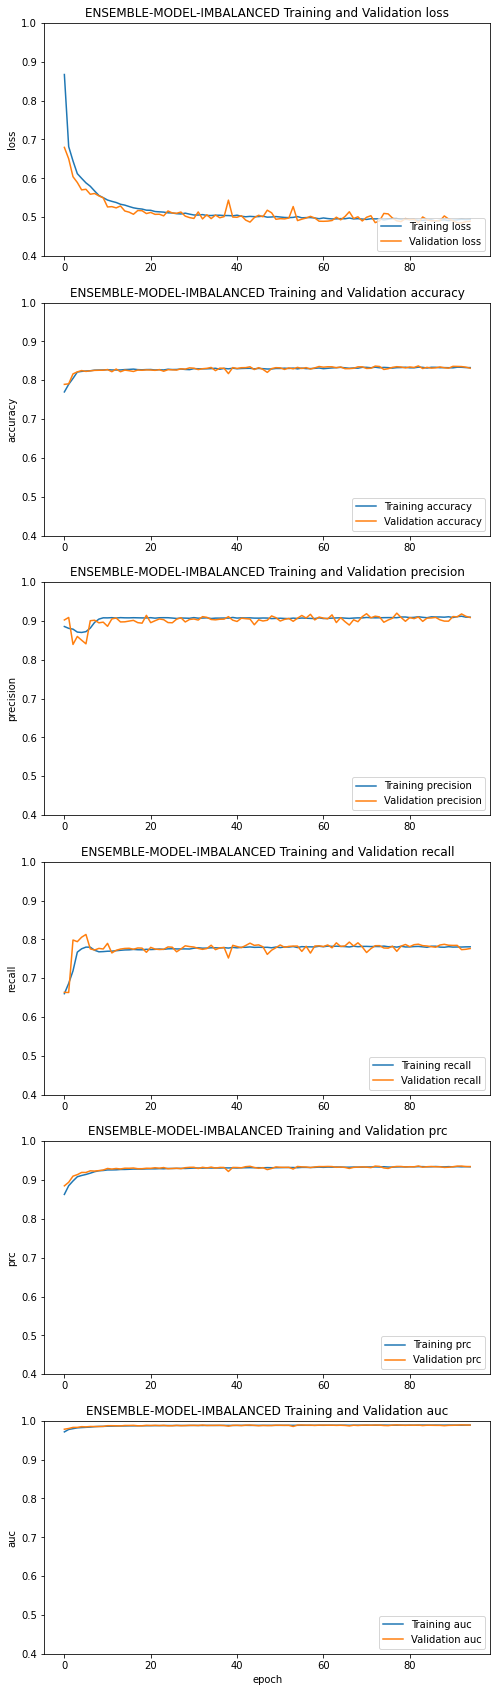

In [72]:
# ENSEMBLE-MODEL-IMBALANCED
dataframe = imbalanced_train.copy()
train_ds= dataframe_to_dataset(dataframe)
dataframe = imbalanced_val.copy()
val_ds= dataframe_to_dataset(dataframe)
dataframe = test.copy()
test_ds= dataframe_to_dataset(dataframe)

print('ENSEMBLE-MODEL-IMBALANCED')
model= evaluation(build_model,train_ds,val_ds,test_ds,'ENSEMBLE-MODEL-IMBALANCED')

ENSEMBLE-MODEL-BALANCED
INFO:tensorflow:Reloading Oracle from existing project hyperparam_dir/HYPERPARAM_ENSEMBLE-MODEL-BALANCED/oracle.json
MODAL-SUMMARY
Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 cartegory_integer_inputs (Inpu  [(None, 28)]        0           []                               
 tLayer)                                                                                          
                                                                                                  
 cartegory_string_inputs (Input  [(None, 3)]         0           []                               
 Layer)                            

INFO:tensorflow:Reloading Tuner from hyperparam_dir/HYPERPARAM_ENSEMBLE-MODEL-BALANCED/tuner0.json
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete for ENSEMBLE-MODEL-BALANCED. The optimal learning rate for the optimizer
    is 0.0001.
    
MODAL-SUMMARY
Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 cartegory_integer_inputs (Inpu  [(None, 28)]        0           []                               
 tLayer)                                                                                          
                                                                                                  
 c

fit model for:ENSEMBLE-MODEL-BALANCED_____________________________________________________________________________________________________________
Epoch 1/25
9250/9250 [==============================] - 4515s 479ms/step - loss: 1.8564 - accuracy: 0.3911 - precision: 0.9148 - recall: 0.1275 - auc: 0.8587 - prc: 0.4631 - val_loss: 1.5039 - val_accuracy: 0.4612 - val_precision: 0.9994 - val_recall: 0.0976 - val_auc: 0.8894 - val_prc: 0.4932
Epoch 2/25
9250/9250 [==============================] - 4175s 451ms/step - loss: 1.4664 - accuracy: 0.4543 - precision: 0.9264 - recall: 0.1220 - auc: 0.8942 - prc: 0.5149 - val_loss: 1.3262 - val_accuracy: 0.5195 - val_precision: 0.9292 - val_recall: 0.1732 - val_auc: 0.9227 - val_prc: 0.6203
Epoch 3/25
9250/9250 [==============================] - 4155s 449ms/step - loss: 1.3066 - accuracy: 0.5424 - precision: 0.8822 - recall: 0.2088 - auc: 0.9217 - prc: 0.6203 - val_loss: 1.2031 - val_accuracy: 0.6397 - val_precision: 0.8932 - val_recall: 0.2624 - va

2313/2313 [==============================] - 172s 74ms/step - loss: 0.8124 - accuracy: 0.7479 - precision: 0.8596 - recall: 0.6398 - auc: 0.9702 - prc: 0.8537
loss:0.8123656511306763 -accuracy:0.747905433177948 - precision:0.8596303462982178 - recall:0.6397972702980042 - auc:0.9702316522598267 - prc:0.8536831736564636
----
----
evaluation result model for:ENSEMBLE-MODEL-BALANCED on TEST________________________________________________________________________________
5480/5480 [==============================] - 408s 74ms/step - loss: 0.9975 - accuracy: 0.7207 - precision: 0.8135 - recall: 0.6952 - auc: 0.9604 - prc: 0.8411
loss:0.9975067973136902 -accuracy:0.7206586003303528 - precision:0.8135353326797485 - recall:0.6951711177825928 - auc:0.960362434387207 - prc:0.8410631418228149
----
----
plot:ENSEMBLE-MODEL-BALANCED_________________________________________________________


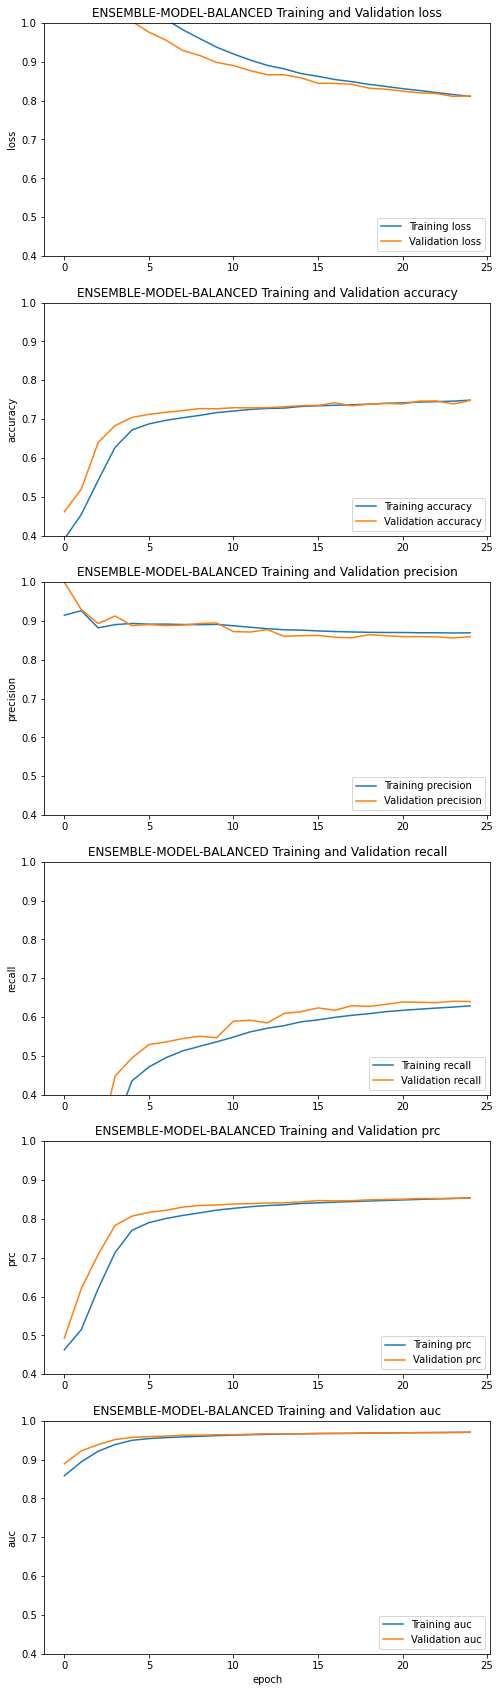

In [79]:
# ENSEMBLE-MODEL-IMBALANCED
dataframe = resampled_train.copy()
train_ds= dataframe_to_dataset(dataframe)
dataframe = resampled_val.copy()
val_ds= dataframe_to_dataset(dataframe)
dataframe = test.copy()
test_ds= dataframe_to_dataset(dataframe)

print('ENSEMBLE-MODEL-BALANCED')
model= evaluation(build_model,train_ds,val_ds,test_ds,'ENSEMBLE-MODEL-BALANCED')

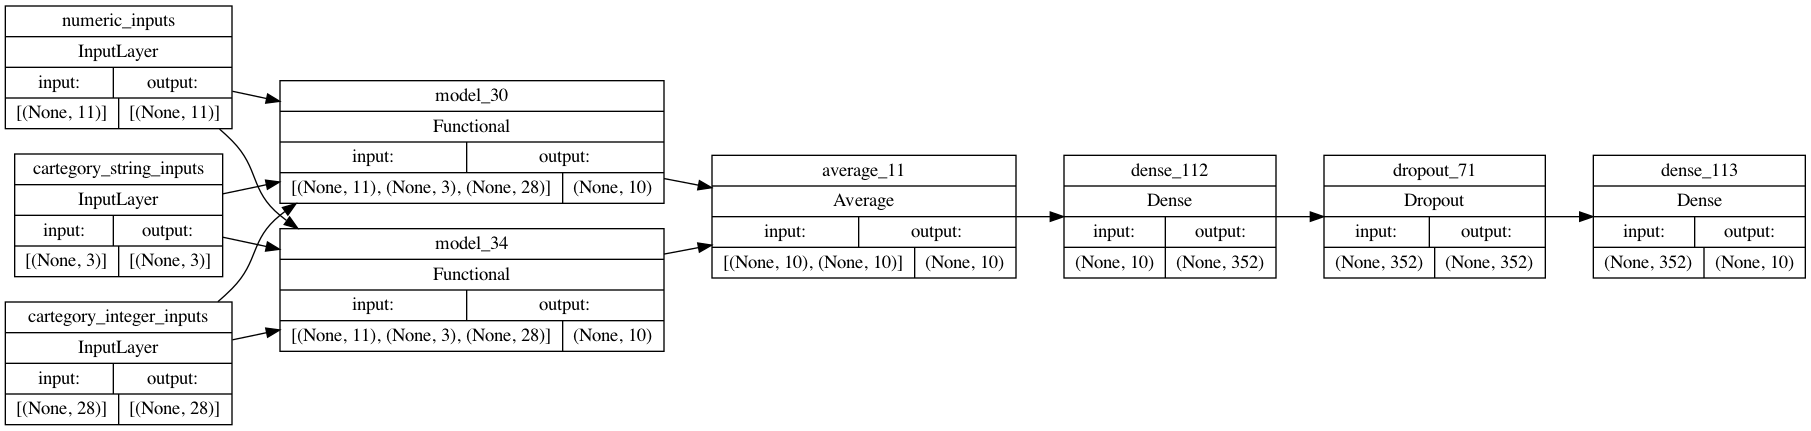

In [81]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [83]:
ENSEMBLE_RESULTS=MODELS_RESULTS

In [84]:
import pickle
with open('ENSEMBLE_RESULTS.dictionary', 'wb') as result_dictionary_file:
    pickle.dump(ENSEMBLE_RESULTS, result_dictionary_file)

In [41]:
project_name='HYPERPARAM_ENSEMBLE-MODEL-IMBALANCED'
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparam_dir',
                     project_name=project_name)
results_summary=tuner.results_summary(num_trials=1)
results_summary

INFO:tensorflow:Reloading Oracle from existing project hyperparam_dir/HYPERPARAM_ENSEMBLE-MODEL-IMBALANCED/oracle.json
MODAL-SUMMARY
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 cartegory_integer_inputs (Inpu  [(None, 28)]        0           []                               
 tLayer)                                                                                          
                                                                                                  
 cartegory_string_inputs (Input  [(None, 3)]         0           []                               
 Layer)                                                   

INFO:tensorflow:Reloading Tuner from hyperparam_dir/HYPERPARAM_ENSEMBLE-MODEL-IMBALANCED/tuner0.json
